# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f'AZDIAS Dataset has {feat_info.shape[0]} rows and {feat_info.shape[1]} columns \n')

print(f'Udacity AZDIAS Subset has {azdias.shape[0]} rows and {azdias.shape[1]} columns')

AZDIAS Dataset has 85 rows and 4 columns 

Udacity AZDIAS Subset has 891221 rows and 85 columns


In [4]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isna().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [9]:
# Copy of the Dataframes
azdias_clean = azdias
feat_info_clean = feat_info

In [10]:
for attribute, index in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    # Parsing the value in string
    missing_values = index.strip('[]').split(',')
    # convert the given values to int if condition is satisfied
    missing_values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_values]
    if missing_values != ['']:
        azdias_clean[attribute] = azdias_clean[attribute].replace(missing_values, np.nan)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# nan_values_count contains the count of NAN values in the columns
nan_values_count = []
for col in azdias_clean.columns:
    nan_values_count.append(azdias_clean[col].isna().sum())
feat_info_clean['nan_values_count'] = nan_values_count
feat_info_clean['Percentage'] = (feat_info_clean['nan_values_count'] / len(azdias)) * 100

# Display the top 5 features with the most NAN values
feat_info_clean.sort_values(by = ['nan_values_count'], ascending = False).head(5)

,attribute,information_level,type,missing_or_unknown,nan_values_count,Percentage
40,TITEL_KZ,person,categorical,"[-1,0]",889061,99.757636
0,AGER_TYP,person,categorical,"[-1,0]",685843,76.955435
47,KK_KUNDENTYP,household,categorical,[-1],584612,65.596749
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]",476524,53.468668
11,GEBURTSJAHR,person,numeric,[0],392318,44.020282


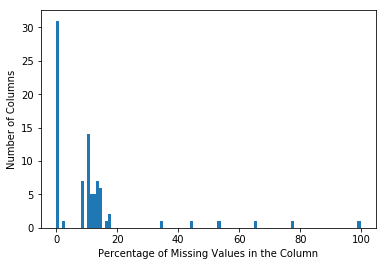

In [12]:
# Investigate patterns in the amount of missing data in each column.
# Percentage of the missing data

plt.hist(feat_info_clean['Percentage'], bins = 100);
plt.xlabel("Percentage of Missing Values in the Column")
plt.ylabel("Number of Columns")
plt.show()

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# An Outlier would be defined as a datapoint residing outside te interquartile range. In this case it would be 
# the number of NAN Counts for the dataset

def outlier_threshold(df):
    Q3 = df['nan_values_count'].quantile(0.75)
    Q1 = df['nan_values_count'].quantile(0.25)
    IQR = Q3 - Q1
    threshold = IQR + (IQR * 1.5)
    
    return threshold

In [14]:
# Calculate outlier threshold
feat_threshold = outlier_threshold(feat_info_clean)

# Determine attributes with outlier NaN counts
outlier_attributes = feat_info_clean[feat_info_clean.nan_values_count > feat_threshold]

# Show attributes with outlier NaN counts
outlier_attributes

,attribute,information_level,type,missing_or_unknown,nan_values_count,Percentage
0,AGER_TYP,person,categorical,"[-1,0]",685843,76.955435
11,GEBURTSJAHR,person,numeric,[0],392318,44.020282
40,TITEL_KZ,person,categorical,"[-1,0]",889061,99.757636
43,ALTER_HH,household,interval,[0],310267,34.813699
47,KK_KUNDENTYP,household,categorical,[-1],584612,65.596749
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]",476524,53.468668


In [15]:
# Dropping the outlier columns

azdias_clean.drop(columns = outlier_attributes['attribute'], inplace = True)

In [16]:
azdias_clean.shape, feat_info_clean.shape, feat_threshold

((891221, 79), (85, 6), 291287.5)

In [17]:
azdias_clean.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column


There were a total of six columns which were removed from the Dataframe. They were:
1. AGER_TYP
2. GEBURTSJAHR
3. TITEL_KZ
4. ALTER_HH
5. KK_KUNDENTYP
6. KBA05_BAUMAX

In order to find out the columns which could be removed, the outliers were first found out. A threshold value of 291287.5 was calculated, which means the Datasets where there were more than 291287.5 Nan values classify as outliers.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?
# checking missing data per row in the Dataframe
azdias_clean["nan_values_count"] = azdias_clean.isnull().sum(axis = 1)

azdias_clean.nan_values_count.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
Name: nan_values_count, dtype: float64

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# We can use the same Outlier principle and the outlier function

row_threshold = outlier_threshold(azdias_clean)

azdias_lower = azdias_clean[azdias_clean.nan_values_count <= row_threshold].copy()
azdias_higher = azdias_clean[azdias_clean.nan_values_count > row_threshold].copy()

In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# We choose columns: 

# Writing a plotting function

def row_plot(df1, df2, attribute):
    plt.figure()
    
    plt.subplot(1, 2, 1)
    sns.countplot(x = attribute, data = df1)
    plt.gca().set_title('Below Threshold')
    
    plt.subplot(1, 2, 2)
    sns.countplot(x = attribute, data = df2)
    plt.gca().set_title('Above Threshold')
    plt.subplots_adjust(bottom=0.2, right=2.5, top=0.9)
    plt.show()

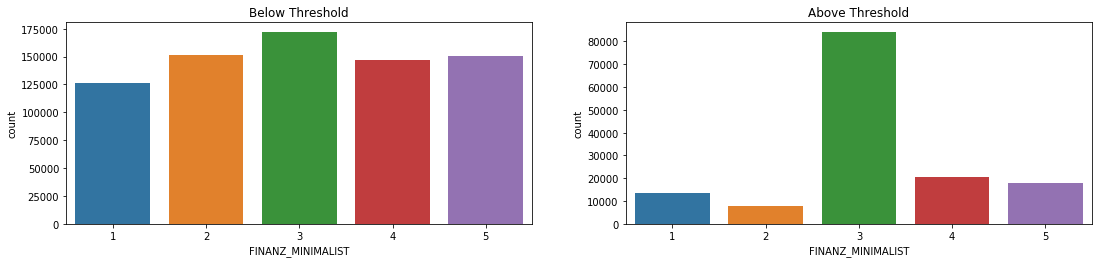

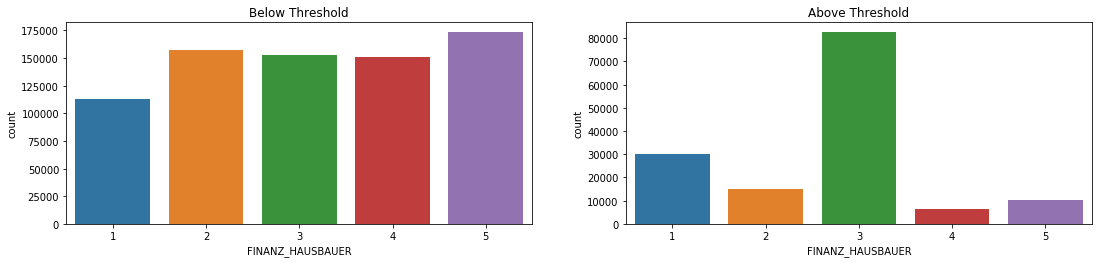

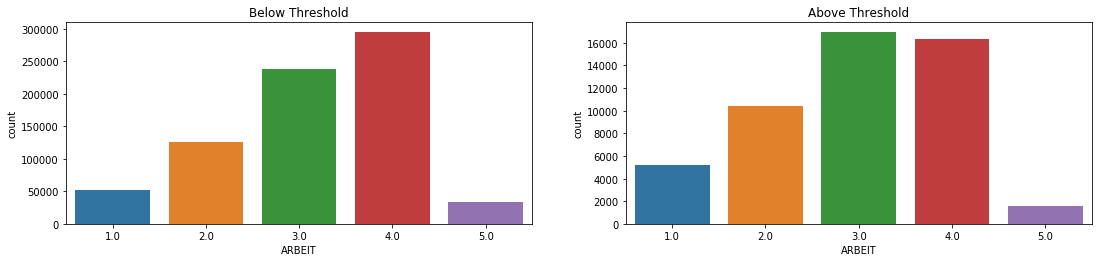

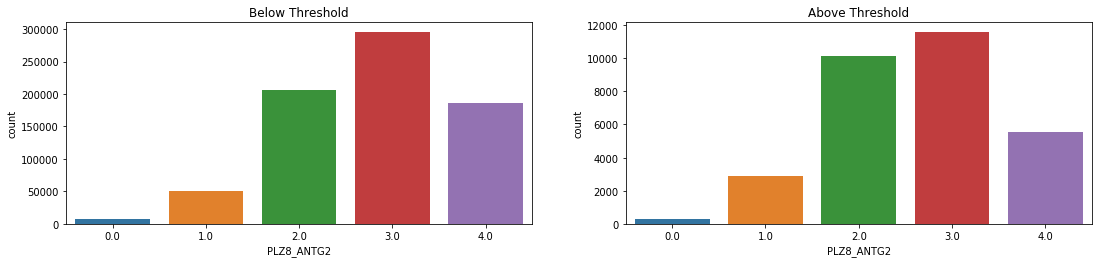

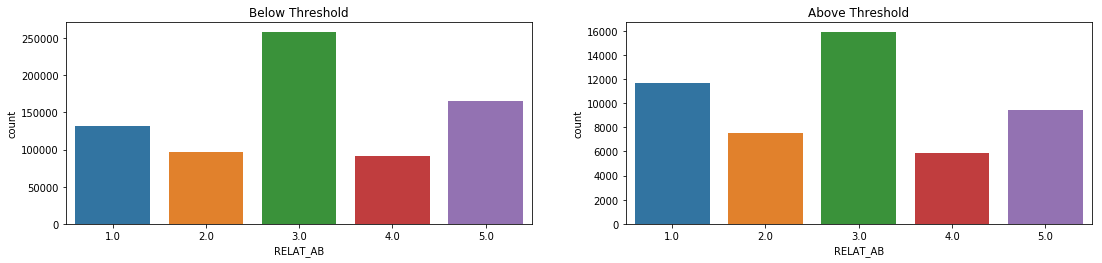

In [21]:
col_list = ['FINANZ_MINIMALIST', 'FINANZ_HAUSBAUER', 'ARBEIT', 'PLZ8_ANTG2', 'RELAT_AB']

for col in col_list:
    row_plot(azdias_lower, azdias_higher, col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Yes, there are significant different differences between the two datatypes. This cannot be seen in many of the columns but in columns such as ARBEIT, FINANZ_MINIMALIST and FINANZ_HAUSBAUER, this can be seen as from the above comparison plots.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?

feat_info = feat_info[feat_info.attribute.isin(azdias_clean.columns)]
feat_info.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [23]:
feat_info_clean_categorical = feat_info[feat_info.type == 'categorical']
feat_info_clean_categorical.attribute

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

binary_categories = []
multi_level_categories = []

for column in feat_info_clean_categorical.attribute:
    if azdias_clean[column].nunique() == 2:
        binary_categories.append(column)
    else:
        multi_level_categories.append(column)

In [25]:
binary_categories

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [26]:
for col in binary_categories:
    print(azdias_clean[col].value_counts())

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


In [27]:
multi_level_categories

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [28]:
for col in multi_level_categories:
    print(col, "has", len(azdias_clean[col].unique()), "unique values \n")

CJT_GESAMTTYP has 7 unique values 

FINANZTYP has 6 unique values 

GFK_URLAUBERTYP has 13 unique values 

LP_FAMILIE_FEIN has 12 unique values 

LP_FAMILIE_GROB has 6 unique values 

LP_STATUS_FEIN has 11 unique values 

LP_STATUS_GROB has 6 unique values 

NATIONALITAET_KZ has 4 unique values 

SHOPPER_TYP has 5 unique values 

ZABEOTYP has 6 unique values 

GEBAEUDETYP has 8 unique values 

CAMEO_DEUG_2015 has 10 unique values 

CAMEO_DEU_2015 has 45 unique values 



In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Drop the categorical variables to be excluded

drop_labels = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
               'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015', 'GEBAEUDETYP']

azdias_lower.drop(columns = drop_labels, inplace = True)
 
# Encode the binary categorical variables

azdias_lower["ANREDE_KZ"].replace({2:0,1:1},inplace=True)

azdias_lower["SOHO_KZ"].replace({0.0:0,1.0:1},inplace=True)

azdias_lower["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)
azdias_lower["OST_WEST_KZ"].astype('int',inplace=True)

azdias_lower["VERS_TYP"].replace({1:0, 2:1},inplace=True)

multi_level = ['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
                   'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015']

azdias_lower=pd.get_dummies(data = azdias_lower, columns = multi_level)

#### Discussion 1.2.1: Re-Encode Categorical Features


Columns kept:
1. LP_FAMILIE_GROB
2. LP_STATUS_GROB
3. NATIONALITAET_KZ
4. SHOPPER_TYP
5. ZABEOTYP
6. CAMEO_DEUG_2015

Columns dropped:
1. CJT_GESAMTTYP
2. FINANZTYP
3. GFK_URLAUBERTYP
4. LP_FAMILIE_FEIN
5. LP_STATUS_FEIN
6. CAMEO_DEU_2015
7. GEBAEUDETYP

Engineering Steps performed:
The binary categorical variables were binary encoded as per the unique categories in the columns.
The multi-level categorical columns kept, were encoded with pd.get_dummies.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
# Checking the mixed variables column names

feat_info_clean[feat_info_clean.type == 'mixed'].attribute

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [31]:
# Dropping the columns other than PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015

drop_labels = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

azdias_lower.drop(columns = drop_labels, inplace = True)

In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_lower['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    172952
8.0     134165
5.0      81722
10.0     80527
3.0      51784
15.0     39536
11.0     33173
9.0      32493
6.0      25120
12.0     23337
4.0      20068
1.0      19583
2.0       7340
13.0      5300
7.0       3888
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [33]:
# Define functions to engineer new features from 'PRAEGENDE_JUGENDJAHRE'

# Movement Function for Mainstream or Avantgarde type
def movement(x):
    if x in [1, 3, 5, 8, 10, 12, 14]:
        # Mainstream
        return 0 
    elif x in [2, 4, 6, 7, 9, 11, 13, 15]:
        #Avantegarde
        return 1 
    else:
        return np.nan

# Decade Interval Function for Generation type
def decade(x):
    if x in [1, 2]:
        return 40
    elif x in [3, 4]:
        return 50
    elif x in [5, 6, 7]:
        return 60
    elif x in [8, 9]:
        return 70
    elif x in [10, 11, 12, 13]:
        return 80
    elif x in [14, 15]:
        return 90
    else:
        return np.nan

# Define function to create and assign new variables
def pj_feature(df):
    # New Feature 'PJ_MOVEMENT' and assign by mapping with function movement
    df['PJ_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement)
    
    # New Feature 'PJ_DECADE' and assign by mapping with function decade
    df['PJ_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade)

In [34]:
pj_feature(azdias_lower)

azdias_lower.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PJ_MOVEMENT,PJ_DECADE
1,1.0,0,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,1,0,0.0,90.0
2,3.0,0,1,4,1,2,3,5,1,3.0,...,0,0,1,0,0,0,0,0,1.0,90.0
3,4.0,0,4,2,5,2,1,2,0,2.0,...,1,0,0,0,0,0,0,0,0.0,70.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,1,0,0,0,0.0,70.0
5,1.0,0,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1,0,0.0,50.0


In [35]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_lower.CAMEO_INTL_2015.value_counts()

51    128033
41     87902
24     85759
14     59027
43     54044
54     43637
25     37564
22     30589
45     25124
13     24528
55     22681
23     20328
52     19627
34     17537
15     16296
31     16285
44     14117
12     11980
35      9882
32      9777
33      9161
Name: CAMEO_INTL_2015, dtype: int64

In [36]:
# Define function to split 'CAMEO_INTL_2015' into two new features
def cameo_feature(df):
    # First digit of 'CAMEO_INTL_2015' to 'CAMEO_WEALTH'
    df['CAMEO_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[0]) if pd.notna(x) else np.nan)
    
    # Second digit of 'CAMEO_INTL_2015' to 'CAMEO_HOUSEHOLD'
    df['CAMEO_HOUSEHOLD'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[1]) if pd.notna(x) else np.nan)

In [37]:
cameo_feature(azdias_lower)

azdias_lower.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PJ_MOVEMENT,PJ_DECADE,CAMEO_WEALTH,CAMEO_HOUSEHOLD
1,1.0,0,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,0.0,90.0,5.0,1.0
2,3.0,0,1,4,1,2,3,5,1,3.0,...,1,0,0,0,0,0,1.0,90.0,2.0,4.0
3,4.0,0,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0.0,70.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,0.0,70.0,4.0,3.0
5,1.0,0,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,0.0,50.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

Features Removed:
1. LP_LEBENSPHASE_FEIN
2. LP_LEBENSPHASE_GROB
3. WOHNLAGE
4. PLZ8_BAUMAX
5. KBA05_BAUMAX

Features Kept:
1. CAMEO_INTL_2015
2. PRAEGENDE_JUGENDJAHRE

PRAEGENDE_JUGENDJAHRE feature is split into two features PRAEGENDE_JUGENDJAHRE and PJ_DECADE, where the features are created depending on the Movment and Decade Categorization.

CAMEO_INTL_2015 feature is split into two features CAMEO_WEALTH and CAMEO_HOUSEHOLD, where the features are created depending on the Wealth and Household Categorization by splitting the digits of the original category.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [38]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Dropping the extra features

drop_labels = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']

azdias_lower.drop(columns = drop_labels, inplace = True)

azdias_lower.shape

(747109, 97)

In [39]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_lower.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747109 entries, 1 to 891220
Data columns (total 97 columns):
ALTERSKATEGORIE_GROB     744640 non-null float64
ANREDE_KZ                747109 non-null int64
FINANZ_MINIMALIST        747109 non-null int64
FINANZ_SPARER            747109 non-null int64
FINANZ_VORSORGER         747109 non-null int64
FINANZ_ANLEGER           747109 non-null int64
FINANZ_UNAUFFAELLIGER    747109 non-null int64
FINANZ_HAUSBAUER         747109 non-null int64
GREEN_AVANTGARDE         747109 non-null int64
HEALTH_TYP               722753 non-null float64
RETOURTYP_BK_S           747109 non-null float64
SEMIO_SOZ                747109 non-null int64
SEMIO_FAM                747109 non-null int64
SEMIO_REL                747109 non-null int64
SEMIO_MAT                747109 non-null int64
SEMIO_VERT               747109 non-null int64
SEMIO_LUST               747109 non-null int64
SEMIO_ERL                747109 non-null int64
SEMIO_KULT               747109 non-n

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [40]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_clean = df
    feat_info_clean = feat_info
    
    for attribute, index in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        # Parsing the value in string
        missing_values = index.strip('[]').split(',')
        # convert the given values to int if condition is satisfied
        missing_values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_values]
        if missing_values != ['']:
            df[attribute] = df[attribute].replace(missing_values, np.nan)
            
    # nan_values_count contains the count of NAN values in the columns
    nan_values_count = []
    for col in df_clean.columns:
        nan_values_count.append(df_clean[col].isna().sum())
    feat_info_clean['nan_values_count'] = nan_values_count
    feat_info_clean['Percentage'] = (feat_info_clean['nan_values_count'] / len(df)) * 100

    def outlier_threshold(dataframe):
        
        Q3 = dataframe['nan_values_count'].quantile(0.75)
        Q1 = dataframe['nan_values_count'].quantile(0.25)
        IQR = Q3 - Q1
        threshold = IQR + (IQR * 1.5)

        return threshold
    
    # Calculate outlier threshold
    feat_threshold = outlier_threshold(feat_info_clean)

    # Determine attributes with outlier NaN counts
    outlier_attributes = feat_info_clean[feat_info_clean.nan_values_count > feat_threshold]
    
    # Dropping the outlier columns

    df.drop(columns = outlier_attributes['attribute'], inplace = True)
    
    # remove selected columns and rows, ...
    # checking missing data per row in the Dataframe
    df_clean["nan_values_count"] = df_clean.isnull().sum(axis = 1)
    
    # We can use the same Outlier principle and the outlier function

    row_threshold = outlier_threshold(df_clean)

    df_lower = df[df_clean.nan_values_count <= row_threshold].copy()

    # select, re-encode, and engineer column values.
    drop_labels = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
               'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015', 'GEBAEUDETYP']

    df_lower.drop(columns = drop_labels, inplace = True)

    # Encode the binary categorical variables

    df_lower["ANREDE_KZ"].replace({2:0,1:1},inplace=True)

    df_lower["SOHO_KZ"].replace({0.0:0,1.0:1},inplace=True)

    df_lower["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)
#     df_lower["OST_WEST_KZ"].astype('int',inplace=True)

    df_lower["VERS_TYP"].replace({1:0, 2:1},inplace=True)

    multi_level = ['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
                       'SHOPPER_TYP', 'ZABEOTYP', 'CAMEO_DEUG_2015']

    df_lower = pd.get_dummies(data = df_lower, columns = multi_level)
    
    drop_labels = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

    df_lower.drop(columns = drop_labels, inplace = True)
    
    
    # Movement Function for Mainstream or Avantgarde type
    def movement(x):
        if x in [1, 3, 5, 8, 10, 12, 14]:
            # Mainstream
            return 0 
        elif x in [2, 4, 6, 7, 9, 11, 13, 15]:
            #Avantegarde
            return 1 
        else:
            return np.nan

    # Decade Interval Function for Generation type
    def decade(x):
        if x in [1, 2]:
            return 40
        elif x in [3, 4]:
            return 50
        elif x in [5, 6, 7]:
            return 60
        elif x in [8, 9]:
            return 70
        elif x in [10, 11, 12, 13]:
            return 80
        elif x in [14, 15]:
            return 90
        else:
            return np.nan

    # Define function to create and assign new variables
    def pj_feature(df):
        # New Feature 'PJ_MOVEMENT' and assign by mapping with function movement
        df['PJ_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement)

        # New Feature 'PJ_DECADE' and assign by mapping with function decade
        df['PJ_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade)
        # Return the cleaned dataframe.
    
    pj_feature(df_lower)

    
    # Define function to split 'CAMEO_INTL_2015' into two new features
    def cameo_feature(df):
        # First digit of 'CAMEO_INTL_2015' to 'CAMEO_WEALTH'
        df['CAMEO_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[0]) if pd.notna(x) else np.nan)

        # Second digit of 'CAMEO_INTL_2015' to 'CAMEO_HOUSEHOLD'
        df['CAMEO_HOUSEHOLD'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x[1]) if pd.notna(x) else np.nan)
        
    cameo_feature(df_lower)

    drop_labels = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']

    df_lower.drop(columns = drop_labels, inplace = True)
    
    return df_lower

In [41]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

azdias_main = clean_data(azdias)
azdias_main.shape

(747109, 97)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [42]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_main.isna().sum()

ALTERSKATEGORIE_GROB      2469
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP               24356
RETOURTYP_BK_S               0
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
VERS_TYP                 24356
ANZ_PERSONEN                 0
ANZ_TITEL                    0
HH_EINKOMMEN_SCORE           0
                         ...  
LP_STATUS_GROB_2.0           0
LP_STATU

In [43]:
# Apply feature scaling to the general population demographics data.

# Using Simple Imputer to impute the dataset with NaN values using the most frequent strategy
impute = Imputer(missing_values = np.nan, strategy = 'most_frequent')
# impute.fit(azdias_main)

azdias_impute = pd.DataFrame(impute.fit_transform(azdias_main), columns = azdias_main.columns.tolist())

azdias_impute.shape

(747109, 97)

In [44]:
# Using Standard Scaler

scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_impute), columns = azdias_main.columns.tolist())

In [45]:
azdias_scaled

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PJ_MOVEMENT,PJ_DECADE,CAMEO_WEALTH,CAMEO_HOUSEHOLD
0,-1.754918,-0.962859,-1.503661,1.559941,-1.049535,1.490708,1.013168,1.331159,-0.536372,1.013071,...,-0.385599,-0.269041,-0.395607,-0.332175,2.188027,-0.399756,-0.536372,1.123587,1.164584,-1.249676
1,0.198237,-0.962859,-1.503661,0.884836,-1.773085,-0.555630,0.291141,1.331159,1.864378,1.013071,...,2.593370,-0.269041,-0.395607,-0.332175,-0.457033,-0.399756,1.864378,1.123587,-0.880212,0.758861
2,1.174815,-0.962859,0.685685,-0.465374,1.121117,-0.555630,-1.152912,-0.831846,-0.536372,-0.309433,...,-0.385599,-0.269041,-0.395607,-0.332175,-0.457033,-0.399756,-0.536372,-0.241508,-1.561811,-0.580164
3,0.198237,1.038573,0.685685,0.209731,0.397566,-1.237743,0.291141,-0.831846,-0.536372,1.013071,...,-0.385599,-0.269041,2.527762,-0.332175,-0.457033,-0.399756,-0.536372,-0.241508,0.482985,0.089348
4,-1.754918,-0.962859,-0.044097,-1.140479,1.121117,-0.555630,-0.430886,1.331159,-0.536372,1.013071,...,-0.385599,-0.269041,-0.395607,-0.332175,2.188027,-0.399756,-0.536372,-1.606603,1.164584,0.758861
5,-0.778341,-0.962859,-1.503661,1.559941,-1.773085,1.490708,1.013168,-0.110844,-0.536372,-0.309433,...,2.593370,-0.269041,-0.395607,-0.332175,-0.457033,-0.399756,-0.536372,0.441040,-0.880212,-0.580164
6,-1.754918,1.038573,-0.044097,0.209731,0.397566,-1.237743,0.291141,-0.831846,-0.536372,-1.631938,...,-0.385599,-0.269041,-0.395607,-0.332175,-0.457033,-0.399756,-0.536372,-0.241508,-1.561811,0.758861
7,0.198237,1.038573,0.685685,0.884836,-1.049535,0.808596,-0.430886,-0.831846,1.864378,1.013071,...,-0.385599,-0.269041,-0.395607,-0.332175,-0.457033,-0.399756,1.864378,0.441040,-1.561811,0.089348
8,0.198237,-0.962859,-0.773879,0.884836,-1.049535,0.126483,1.735195,0.610157,1.864378,-0.309433,...,-0.385599,-0.269041,-0.395607,-0.332175,-0.457033,-0.399756,1.864378,1.123587,-1.561811,1.428373
9,0.198237,-0.962859,-0.773879,-0.465374,1.121117,0.126483,-1.152912,1.331159,-0.536372,-0.309433,...,-0.385599,-0.269041,-0.395607,-0.332175,-0.457033,2.501528,-0.536372,-1.606603,1.164584,-1.249676


### Discussion 2.1: Apply Feature Scaling

Standard Scaler was used to standardize the dataset. To standardize the dataset, it was however, first necessary that the dataset did not contain any NaN values. Therefore, using Imputer with most_frequent strategy, the NaN values were removed from the dataset. 

Also, the method fit_transform was used to fit as well as transform the data in the same command.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [46]:
# Apply PCA to the data.

pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

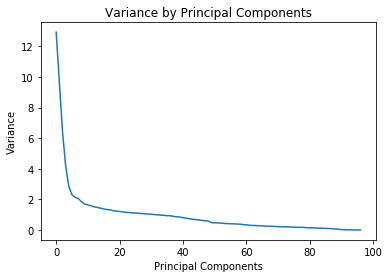

In [47]:
# Investigate the variance accounted for by each principal component.

plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_);
plt.xlabel('Principal Components');
plt.ylabel('Variance');
plt.title('Variance by Principal Components');
plt.show()

In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_50 = PCA(n_components=50)
pca_final = pca_50.fit_transform(azdias_scaled)
pca_final

array([[ 4.33720868, -2.78747077, -3.10398147, ...,  0.06632536,
         0.14965824, -0.02302272],
       [-0.71888712, -0.12166984, -3.46141293, ..., -0.04799013,
        -1.15730289,  0.44734833],
       [-4.20138954,  1.63843361, -0.86771743, ...,  1.0059069 ,
        -1.00934197,  0.53209253],
       ..., 
       [-0.96791313, -3.35741312, -3.41441813, ...,  1.48923392,
        -2.19899149,  0.43981534],
       [ 5.90030452, -3.84419091,  2.73862454, ...,  0.32784606,
        -0.86680182, -0.09185127],
       [-0.064499  ,  1.78021333,  2.66983975, ...,  0.419892  ,
         0.60893252, -0.11421469]])

### Discussion 2.2: Perform Dimensionality Reduction

PCA with 50 Components are chosen (reduced number) after seeing a decrease in the variance

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [49]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_mapping(pca, i):
    data = pd.DataFrame(pca_50.components_, columns = azdias_main.columns.tolist())
    return data.iloc[i].sort_values(ascending = False)


In [50]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_zero = pca_mapping(pca_final, 0)
pca_zero

LP_STATUS_GROB_1.0       0.209040
PLZ8_ANTG3               0.202878
CAMEO_WEALTH             0.198948
HH_EINKOMMEN_SCORE       0.198832
PLZ8_ANTG4               0.196171
ORTSGR_KLS9              0.172290
EWDICHTE                 0.170216
FINANZ_HAUSBAUER         0.155057
KBA05_ANTG4              0.140729
PLZ8_ANTG2               0.138041
KBA05_ANTG3              0.128452
ARBEIT                   0.128017
FINANZ_SPARER            0.127819
ANZ_HAUSHALTE_AKTIV      0.125598
CAMEO_DEUG_2015_9        0.122347
RELAT_AB                 0.119834
CAMEO_DEUG_2015_8        0.099076
SEMIO_PFLICHT            0.096533
SEMIO_REL                0.090781
PJ_DECADE                0.089714
ZABEOTYP_5               0.085404
LP_FAMILIE_GROB_1.0      0.083117
SEMIO_RAT                0.082060
SEMIO_TRADV              0.074284
SEMIO_MAT                0.067853
REGIOTYP                 0.062710
SEMIO_FAM                0.062024
FINANZ_UNAUFFAELLIGER    0.061631
FINANZ_ANLEGER           0.060421
NATIONALITAET_

In [51]:
pca_one = pca_mapping(pca_final, 1)
pca_one

ALTERSKATEGORIE_GROB     0.248100
FINANZ_VORSORGER         0.223210
ZABEOTYP_3               0.218263
SEMIO_ERL                0.218093
SEMIO_LUST               0.173028
RETOURTYP_BK_S           0.158623
W_KEIT_KIND_HH           0.114928
SEMIO_KRIT               0.108796
FINANZ_HAUSBAUER         0.103115
SEMIO_KAEM               0.098592
SHOPPER_TYP_3.0          0.091857
PLZ8_ANTG3               0.075819
EWDICHTE                 0.072128
PLZ8_ANTG4               0.071875
FINANZ_MINIMALIST        0.071678
ORTSGR_KLS9              0.070954
NATIONALITAET_KZ_1.0     0.070011
CAMEO_WEALTH             0.064223
SEMIO_DOM                0.058904
KBA05_ANTG4              0.058321
WOHNDAUER_2008           0.056014
LP_FAMILIE_GROB_1.0      0.055332
ARBEIT                   0.055043
RELAT_AB                 0.052354
PLZ8_ANTG2               0.052277
ANZ_HAUSHALTE_AKTIV      0.051029
HH_EINKOMMEN_SCORE       0.045641
CAMEO_DEUG_2015_8        0.041165
KBA05_ANTG3              0.038180
LP_FAMILIE_GRO

In [52]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_two = pca_mapping(pca_final, 2)
pca_two

ANREDE_KZ                0.353968
SEMIO_VERT               0.331558
SEMIO_SOZ                0.257857
SEMIO_FAM                0.247008
SEMIO_KULT               0.228698
FINANZ_MINIMALIST        0.142328
SHOPPER_TYP_0.0          0.127241
RETOURTYP_BK_S           0.105839
ZABEOTYP_1               0.102962
W_KEIT_KIND_HH           0.093200
FINANZ_VORSORGER         0.090280
SEMIO_REL                0.080303
ALTERSKATEGORIE_GROB     0.064967
SEMIO_MAT                0.058497
SEMIO_LUST               0.056742
ORTSGR_KLS9              0.054891
EWDICHTE                 0.054810
PLZ8_ANTG4               0.053487
PLZ8_ANTG3               0.053332
GREEN_AVANTGARDE         0.050895
PJ_MOVEMENT              0.050895
ZABEOTYP_6               0.050598
SHOPPER_TYP_1.0          0.041623
ARBEIT                   0.037507
PLZ8_ANTG2               0.036464
LP_STATUS_GROB_5.0       0.036353
RELAT_AB                 0.035711
CAMEO_WEALTH             0.033327
KBA05_ANTG4              0.032538
WOHNDAUER_2008

### Discussion 2.3: Interpret Principal Components

1. Principal Component One
LP_STATUS_GROB_1.0 has the strongest value for the first principal component. It relates to the social status, and gives information about the earning of the person in terms from low-income to top earners.

2. Principal Component Two
ALTERSKATEGORIE_GROB has the strongest value for the second principal component. It relates to the age ranges of the people. 

3. Principal Component Three
ANREDE_KZ has the strongest value for the third principal component. It relates to the gender

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [64]:
# Over a number of different cluster counts...
num_clusters=np.arange(1,15)
scores=[]

for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(pca_final)
    # compute the average within-cluster distances.
    score = np.abs(model.score(pca_final))
    scores.append(score)
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


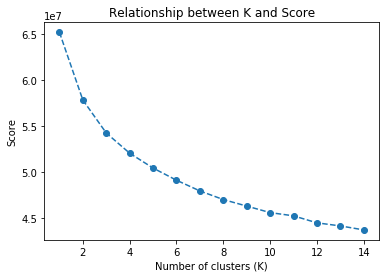

In [65]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(num_clusters, scores, marker='o', linestyle='--')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Score')
plt.title("Relationship between K and Score")
plt.show()

In [66]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 12)
KMeans_model_12 = kmeans.fit(pca_final)
pred_azdias = KMeans_model_12.predict(pca_final)

### Discussion 3.1: Apply Clustering to General Population

Looking at the Scree plot, I infer that the score decreases after 12 Clusers, hence I decided to segment the population into 12 Clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [67]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers_df = clean_data(customers)

customers_df.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PJ_MOVEMENT,PJ_DECADE,CAMEO_WEALTH,CAMEO_HOUSEHOLD
0,2.0,4.0,1,5,1,5,1,2,2,NaN,...,0,0,0,0,0,0,1.0,50.0,1.0,3.0
1,NaN,4.0,1,5,1,5,1,3,2,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,NaN,4.0,0,5,1,5,1,4,4,NaN,...,0,1,0,0,0,0,1.0,50.0,3.0,4.0
3,1.0,4.0,1,5,1,5,2,1,2,NaN,...,1,0,0,0,0,0,0.0,40.0,2.0,4.0
4,NaN,3.0,1,3,1,4,4,5,2,1960.0,...,0,0,0,1,0,0,0.0,70.0,4.0,1.0


In [68]:
drop_labels = []

for col in customers_df.columns:
    if col not in azdias_main.columns:
        drop_labels.append(col)

In [69]:
drop_labels

['AGER_TYP', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

In [70]:
# Drop the extra columns from the Customers Dataset
customers_df.drop(columns = drop_labels, inplace = True)

# Impute the Customers Dataset using Azdias Imputer
customers_impute = pd.DataFrame(impute.transform(customers_df), columns = customers_df.columns.tolist())

# Scale the imputed customer dataset using previous scaler
customers_scaled = pd.DataFrame(scaler.transform(customers_impute), columns = customers_impute.columns.tolist())

customers_scaled.shape

(191652, 97)

In [71]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_pca = pca_50.transform(customers_scaled)

customers_pred = KMeans_model_12.predict(customers_pca)

In [72]:
customers_pred

array([2, 3, 7, ..., 2, 6, 3], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [73]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general = []
customers = []

x = [i+1 for i in range(12)]
for i in range(12):
    general.append((pred_azdias == i).sum()/len(pred_azdias))
    customers.append((customers_pred == i).sum()/len(customers_pred))
    
df_proportion = pd.DataFrame({'Clusters' : x, 'General Pop Proportion' :  general, 'Customer Pop Proportion': customers})

In [74]:
df_proportion.head()

,Clusters,General Pop Proportion,Customer Pop Proportion
0,1,0.132354,0.086151
1,2,0.123772,0.071118
2,3,0.071686,0.236611
3,4,0.106085,0.145274
4,5,0.073217,0.005578


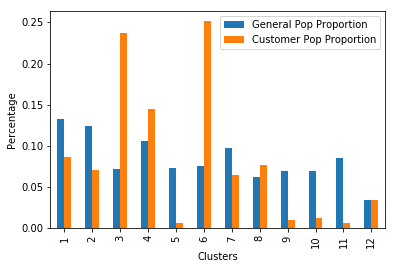

In [75]:
df_proportion.plot(x='Clusters', kind='bar');
plt.ylabel('Percentage');

In [79]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

overrepresented = scaler.inverse_transform(pca_50.inverse_transform(KMeans_model_12.cluster_centers_[3]))
df_overrepresented = pd.Series(data = overrepresented, index = customers_df.columns)

In [80]:
df_overrepresented

ALTERSKATEGORIE_GROB      3.303801
ANREDE_KZ                 0.902920
FINANZ_MINIMALIST         4.555804
FINANZ_SPARER             1.741697
FINANZ_VORSORGER          4.161910
FINANZ_ANLEGER            2.169301
FINANZ_UNAUFFAELLIGER     1.862345
FINANZ_HAUSBAUER          2.128983
GREEN_AVANTGARDE          0.000825
HEALTH_TYP                2.367430
RETOURTYP_BK_S            3.785422
SEMIO_SOZ                 4.803552
SEMIO_FAM                 4.673745
SEMIO_REL                 3.701008
SEMIO_MAT                 3.274875
SEMIO_VERT                5.765172
SEMIO_LUST                4.830425
SEMIO_ERL                 4.374236
SEMIO_KULT                4.832017
SEMIO_RAT                 2.622748
SEMIO_KRIT                3.652174
SEMIO_DOM                 3.213406
SEMIO_KAEM                2.690547
SEMIO_PFLICHT             3.337474
SEMIO_TRADV               2.989438
SOHO_KZ                   0.007157
VERS_TYP                  0.622817
ANZ_PERSONEN              1.812123
ANZ_TITEL           

In [81]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented = scaler.inverse_transform(pca_50.inverse_transform(KMeans_model_12.cluster_centers_[1]))
df_underrepresented = pd.Series(data = underrepresented, index = customers_df.columns)

In [82]:
df_underrepresented

ALTERSKATEGORIE_GROB      3.550778
ANREDE_KZ                 0.022664
FINANZ_MINIMALIST         2.458490
FINANZ_SPARER             1.860495
FINANZ_VORSORGER          4.368032
FINANZ_ANLEGER            2.236780
FINANZ_UNAUFFAELLIGER     1.700213
FINANZ_HAUSBAUER          4.439494
GREEN_AVANTGARDE          0.057179
HEALTH_TYP                2.001106
RETOURTYP_BK_S            4.276122
SEMIO_SOZ                 3.014925
SEMIO_FAM                 2.164711
SEMIO_REL                 1.982308
SEMIO_MAT                 2.491159
SEMIO_VERT                2.673709
SEMIO_LUST                5.335775
SEMIO_ERL                 6.529838
SEMIO_KULT                1.842256
SEMIO_RAT                 3.372924
SEMIO_KRIT                5.861378
SEMIO_DOM                 5.800693
SEMIO_KAEM                6.106297
SEMIO_PFLICHT             2.799189
SEMIO_TRADV               2.348652
SOHO_KZ                   0.007325
VERS_TYP                  0.650388
ANZ_PERSONEN              1.397611
ANZ_TITEL           

### Discussion 3.3: Compare Customer Data to Demographics Data

For Clusters 3, 4, 6 and 8, we can observe a great amount of overrepresentation.

In contrast to that, in Clusters 1, 2, 9, 11 and 12, we can observe a decent amount of overrepresentation.

The popular segments are people from age groups 46 to 60, with health type of jaunty hedonists and high income.

The unpopular segments are people with very high religiuo and high income.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.